In [14]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [320]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [16]:
from src.reg_classifier import *

In [17]:
df = pd.read_csv('./data/AB_NYC_2019_EDA.csv').drop(['Unnamed: 0'], axis=1)

target_name = 'price'

In [322]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Test ClassRegressor

In [323]:
df.head()

,neighbourhood,price,availability_365,n-hood_group_Brooklyn,n-hood_group_Manhattan,n-hood_group_Queens,n-hood_group_Staten Island,room_type_Private room,room_type_Shared room,Manh_dist,Broo_dist,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count
0,92.669640,149,365,1,0,0,0,1,0,0.133675,0.025206,0.693147,2.302585,-1.560648,1.791759
1,252.614598,225,355,0,1,0,0,0,0,0.032827,0.108917,0.693147,3.828641,-0.967584,0.693147
2,109.915169,150,365,0,1,0,0,1,0,0.036737,0.158162,1.386294,0.000000,-0.328504,0.000000
3,140.791735,89,194,1,0,0,0,0,0,0.096037,0.036351,0.693147,5.602119,1.534714,0.000000
4,121.010757,80,0,0,1,0,0,0,0,0.027858,0.147596,2.397895,2.302585,-2.302585,0.000000


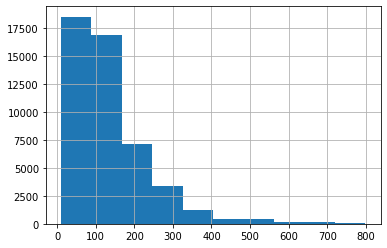

In [324]:
df[target_name].hist()

In [325]:
df[target_name].describe()

count    48410.000000
mean       137.575170
std        103.780081
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        799.000000
Name: price, dtype: float64

In [346]:
clf = ClassRegressor(n_bins=2)

In [347]:
X, y = df.drop(columns=[target_name]), df[target_name]

In [348]:
clf.fit(X, y)

In [349]:
clf.bin_borders

{0: [10.0, 404.5], 1: [404.5, 799.0]}

In [350]:
clf.y_classes

array([0, 0, 0, ..., 0, 0, 0])

In [351]:
pd.Series(clf.y_classes).value_counts()

0    47126
1     1284
dtype: int64

In [352]:
df[target_name][clf.y_classes.astype(bool)].describe()

count    1284.000000
mean      545.380062
std       103.736305
min       407.000000
25%       452.750000
50%       500.000000
75%       600.000000
max       799.000000
Name: price, dtype: float64

In [353]:
df[target_name][~clf.y_classes.astype(bool)].describe()

count    47126.000000
mean       126.464075
std         78.205286
min         10.000000
25%         67.000000
50%        100.000000
75%        165.000000
max        404.000000
Name: price, dtype: float64

In [354]:
clf.predict(X.values[0:1])

array([0])

In [355]:
clf.predict(X.values[0:1], regression=True)

array([207.25])

In [356]:
pd.Series(clf.predict(X)).value_counts()

0    48392
1       18
dtype: int64

In [357]:
pd.Series(clf.predict(X, regression=True)).value_counts()

207.25    48392
601.75       18
dtype: int64

In [361]:
clf = ClassRegressor(n_bins=5)
clf.fit(X_train_scaled, y_train)

In [362]:
pred_train = clf.predict(X_train_scaled, regression=True)
pred_test = clf.predict(X_test_scaled, regression=True)

print('Class regressor')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Class regressor
train mae 58.98732552306194
test mae 59.61759278386009


In [363]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_scaled, y_train)


pred_train = dummy_regr.predict(X_train_scaled)
pred_test = dummy_regr.predict(X_test_scaled)

print('Dummy regressor')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Dummy regressor
train mae 73.16229704247705
test mae 73.86817388705516


# Test ClassRegressorEnsemble

In [436]:
N_BINS = 2
N_LEVELS = 3

class_reg = ClassRegressorEnsemble(n_bins=BINS_NUMB, n_levels=N_LEVELS)

class_reg.fit(X_train_scaled, y_train)

In [437]:
class_reg.models

{(0, 0, None): <src.reg_classifier.ClassRegressor at 0x7fa6c8a227c0>,
 (1, 0, (0, 0)): <src.reg_classifier.ClassRegressor at 0x7fa6c8a22bb0>,
 (2, 0, (1, 0)): <src.reg_classifier.ClassRegressor at 0x7fa6c8a22d30>,
 (2, 1, (1, 0)): <src.reg_classifier.ClassRegressor at 0x7fa6c8a22c10>,
 (1, 1, (0, 0)): <src.reg_classifier.ClassRegressor at 0x7fa6c8a09580>,
 (2, 0, (1, 1)): <src.reg_classifier.ClassRegressor at 0x7fa6c8a09be0>,
 (2, 1, (1, 1)): <src.reg_classifier.ClassRegressor at 0x7fa6c8ab8b50>}

In [438]:
class_reg.models[(0, 0, None)].bin_borders

{0: [10.0, 404.5], 1: [404.5, 799.0]}

In [439]:
class_reg.models[(1, 0, (0, 0))].bin_borders

{0: [10.0, 207.0], 1: [207.0, 404.0]}

In [440]:
class_reg.models[(1, 1, (0, 0))].bin_borders

{0: [407.0, 603.0], 1: [603.0, 799.0]}

In [441]:
X_train_scaled.iloc[0], y_train.iloc[0]

(neighbourhood                         0.049058
 availability_365                      0.359398
 n-hood_group_Brooklyn                 1.192500
 n-hood_group_Manhattan               -0.881253
 n-hood_group_Queens                  -0.368839
 n-hood_group_Staten Island           -0.088101
 room_type_Private room               -0.923396
 room_type_Shared room                -0.155793
 Manh_dist                            -0.176716
 Broo_dist                            -0.582332
 log_minimum_nights                    1.025703
 log_number_of_reviews                -0.836802
 log_reviews_per_month                 0.133774
 log_calculated_host_listings_count   -0.515268
 Name: 0, dtype: float64,
 150)

In [448]:
class_reg.models[(0, 0, None)].predict(X_train_scaled.iloc[:1])

array([0])

In [450]:
class_reg.predict(X_train_scaled.iloc[:1])

(0, 0, None)
(1, 0, (0, 0))
(2, 0, (1, 0))
(3, 1, (2, 0))


array([157.75])

In [452]:
pred_test = class_reg.predict(X_test_scaled)

In [453]:
pd.Series(pred_test).value_counts()

59.25     7436
157.75    6165
256.25     905
455.25      17
dtype: int64

In [454]:
pred_train = class_reg.predict(X_train_scaled)
pred_test = class_reg.predict(X_test_scaled)

print('Simple ClassRegressor ensemble')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Simple ClassRegressor ensemble
train mae 51.13694779709033
test mae 52.17009226743786


# Test large ClassRegressorEnsemble

In [487]:
N_BINS = 10
N_LEVELS = 3

class_reg = ClassRegressorEnsemble(n_bins=BINS_NUMB, n_levels=N_LEVELS)

In [488]:
class_reg.fit(X_train_scaled, y_train)

In [489]:
class_reg.models

{(0, 0, None): <src.reg_classifier.ClassRegressor at 0x7fa6c8aa1220>,
 (1, 0, (0, 0)): <src.reg_classifier.ClassRegressor at 0x7fa6c8a105b0>,
 (2, 0, (1, 0)): <src.reg_classifier.ClassRegressor at 0x7fa6c8afa130>,
 (2, 1, (1, 0)): <src.reg_classifier.ClassRegressor at 0x7fa6c8aa1610>,
 (1, 1, (0, 0)): <src.reg_classifier.ClassRegressor at 0x7fa6c8a308b0>,
 (2, 0, (1, 1)): <src.reg_classifier.ClassRegressor at 0x7fa6c8a307c0>,
 (2, 1, (1, 1)): <src.reg_classifier.ClassRegressor at 0x7fa6c8ab8cd0>}

In [490]:
pred_train = class_reg.predict(X_train_scaled)

In [491]:
print('Train errors')
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

measured_metrics["class_reg"] = dataframe_metrics(y_train, pred_train)
measured_metrics

Train errors


,error_type,class_reg
0,MAE,51.136948
1,RMSE,86.533610
2,R2,0.296855
3,MAPE,35.897691


In [492]:
pred_test = class_reg.predict(X_test_scaled)

In [493]:
print('Test errors')
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

measured_metrics["class_reg"] = dataframe_metrics(y_test, pred_test)
measured_metrics

Test errors


,error_type,class_reg
0,MAE,52.170092
1,RMSE,88.027354
2,R2,0.298664
3,MAPE,35.605572


In [494]:
lgbm_reg = LGBMRegressor()

lgbm_reg.fit(X_train_scaled, y_train)

measured_metrics["baseline_lgbm"] = dataframe_metrics(y_test, lgbm_reg.predict(X_test_scaled))
measured_metrics

,error_type,class_reg,baseline_lgbm
0,MAE,52.170092,45.121954
1,RMSE,88.027354,73.961575
2,R2,0.298664,0.504888
3,MAPE,35.605572,35.237009
